# MindLogger Flanker Data Check - 03/24/22 dataset

In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

In [122]:
sns.set_context("notebook")

### Create dictionaries to map trial_type values to dimensions of interest

In [123]:
flanker_type = {1:"Neutral", 2:"Neutral", 3:"Congruent", 4:"Congruent", 5:"Incongruent", 6:"Incongruent"}
left_right = {1:"L", 2:"R", 3:"L", 4:"R", 5:"L", 6:"R"}

### Load and map values

In [124]:
def load_flanker(prefix):
    DF = pd.read_csv(f"{prefix}_test1.csv")
    for k in [2,3]:
        tmp = pd.read_csv(f"{prefix}_test{k}.csv")
        DF = pd.concat([DF, tmp], ignore_index=True)
    return(DF)

In [125]:
df = load_flanker("623933705197b94689825e8d")
df["flanker_type"] = df.trial_type.map(flanker_type)
df["correct_resp"] = df.trial_type.map(left_right)
df.head(n=10)

,block_number,trial_number,trial_type,event_type,experiment_start_timestamp,block_start_timestamp,trial_start_timestamp,event_start_timestamp,video_display_request_timestamp,response_touch_timestamp,trial_offset,event_offset,response_time,response,response_accuracy,flanker_type,correct_resp
0,1,1,6,Fixation,1647915482083,1647915537228,1647915537228,1647915537228,1647915537228,.,0,0,.,.,.,Incongruent,R
1,1,1,6,Stimulus,1647915482083,1647915537228,1647915537228,1647915537732,1647915537733,.,0,504,.,.,.,Incongruent,R
2,1,1,6,Response,.,.,.,.,.,1647915538353,0,.,620.0000000000002,R,1,Incongruent,R
3,1,2,2,Fixation,1647915482083,1647915537228,1647915538354,1647915538354,1647915538354,.,1126,0,.,.,.,Neutral,R
4,1,2,2,Stimulus,1647915482083,1647915537228,1647915538354,1647915538857,1647915538858,.,1126,503,.,.,.,Neutral,R
5,1,2,2,Response,.,.,.,.,.,1647915539263,1126,.,405,R,1,Neutral,R
6,1,3,4,Fixation,1647915482083,1647915537228,1647915539264,1647915539264,1647915539264,.,2036,0,.,.,.,Congruent,R
7,1,3,4,Stimulus,1647915482083,1647915537228,1647915539264,1647915539767,1647915539768,.,2036,503,.,.,.,Congruent,R
8,1,3,4,Response,.,.,.,.,.,1647915540157,2036,.,389,R,1,Congruent,R
9,1,4,5,Fixation,1647915482083,1647915537228,1647915540158,1647915540158,1647915540158,.,2930,0,.,.,.,Incongruent,L


## Split into three event types

In [126]:
# copying as new dataframes, rather than creating a view.
# not 100% necessary, but prevents inadvertent errors and 
# avoids upsetting Pandas
resp = df[df.event_type == "Response"].copy()
fix = df[df.event_type == "Fixation"].copy()
stim = df[df.event_type == "Stimulus"].copy()

## All data are saved as fully-quoted strings with missing values non-overlapping event time columns, so we need to convert relevant columns to appropriate numeric values

In [127]:
# Non-response events
non_resp_ints = ['experiment_start_timestamp',
 'block_start_timestamp',
 'trial_start_timestamp',
 'event_start_timestamp',
 'video_display_request_timestamp',
 'trial_offset',
 'event_offset']
# Response events
response_ints = ['response_touch_timestamp',
 'trial_offset',
 'response_accuracy']

for n in non_resp_ints:
    fix[n] = fix[n].map(int)
    stim[n] = stim[n].map(int)

for r in response_ints:
    resp[r] = resp[r].map(int)

resp.response_time = resp.response_time.map(float)

## Quick sanity checks on Response data

### Overall Mean RT

In [128]:
resp.groupby("flanker_type").response_time.mean()

flanker_type
Congruent      424.225
Incongruent    475.050
Neutral        419.025
Name: response_time, dtype: float64

#### RTs match expectations for relative RTs (N<C<I), at least nominally [above]

### Overall Mean Accuracy

In [129]:
resp.groupby("flanker_type").response_accuracy.mean() * 100

flanker_type
Congruent      96.666667
Incongruent    76.666667
Neutral        90.833333
Name: response_accuracy, dtype: float64

#### Accuracy at least shows I < C,N - But this could just be an idiosyncracy of the test subject [above]

### RTs for Correct Trials Only

In [130]:
resp[resp.response_accuracy == 1].groupby("flanker_type").response_time.mean()

flanker_type
Congruent      423.250000
Incongruent    499.880435
Neutral        427.844037
Name: response_time, dtype: float64

#### Excluding error trials sharpens the overall pattern [above]

### Left vs. Right

In [131]:
resp[resp.response_accuracy == 1].groupby("response").response_time.mean()

response
L    455.200000
R    438.783439
Name: response_time, dtype: float64

#### Handedness also lines up, given a right-handed participant [above]

### On first pass, the behavioral data look sensible

## Flatten Data

### Wide format is much easier to deal with in virtually all analytic frameworks.<br> Much of the data in stim and fix rows is redundant; also creating sanity checking variables more immediately interpretable than long ints

In [132]:
flat = fix[["block_number",
           "trial_number",
           "trial_type",
           'experiment_start_timestamp',
           'block_start_timestamp',
           'trial_start_timestamp']].copy()
flat["flanker_type"] = resp.flanker_type.values
flat["stim_trial_start_ts"] = stim.event_start_timestamp.values
flat["stim_display_request_ts"] = stim.video_display_request_timestamp.values
flat["response_timestamp"] = resp.response_touch_timestamp.values
flat["response_time"] = resp.response_time.values
flat["response_accuracy"] = resp.response_accuracy.values
flat["block_to_fix_time"] = flat.trial_start_timestamp - flat.block_start_timestamp
flat["fix_to_stim_time"] = flat.stim_trial_start_ts - flat.trial_start_timestamp
flat["stim_time_to_display_time"] = flat.stim_display_request_ts - flat.stim_trial_start_ts
flat["stim_to_response"] = flat.response_timestamp - flat.stim_display_request_ts # sanity check that response_time matches values directly computed from columns

flat.head(n=5)

,block_number,trial_number,trial_type,experiment_start_timestamp,block_start_timestamp,trial_start_timestamp,flanker_type,stim_trial_start_ts,stim_display_request_ts,response_timestamp,response_time,response_accuracy,block_to_fix_time,fix_to_stim_time,stim_time_to_display_time,stim_to_response
0,1,1,6,1647915482083,1647915537228,1647915537228,Incongruent,1647915537732,1647915537733,1647915538353,620.0,1,0,504,1,620
3,1,2,2,1647915482083,1647915537228,1647915538354,Neutral,1647915538857,1647915538858,1647915539263,405.0,1,1126,503,1,405
6,1,3,4,1647915482083,1647915537228,1647915539264,Congruent,1647915539767,1647915539768,1647915540157,389.0,1,2036,503,1,389
9,1,4,5,1647915482083,1647915537228,1647915540158,Incongruent,1647915540661,1647915540661,1647915540959,298.0,0,2930,503,0,298
12,1,5,1,1647915482083,1647915537228,1647915540960,Neutral,1647915541463,1647915541463,1647915541844,381.0,1,3732,503,0,381


In [133]:
d = dict(flat.stim_time_to_display_time.value_counts())
v = pd.DataFrame(columns=["time_interval_ms","count_at_interval"])
v.time_interval_ms = d.keys()
v.count_at_interval = d.values()
v.sort_values("time_interval_ms").head()

,time_interval_ms,count_at_interval
0,0,278
1,1,82


#### The stim display request times are virtually perfectly aligned with the stim start times, with a max variation of 1ms on only ~23% of trials
This might seem good, but it just underscores that the true display times are divorced from the recorded display times. <br>Well, maybe not divorced, but at least estranged. This will be obvious to anyone looking closely at the output.

## Check response to next trial time interval

In [134]:
resp_to_next_interval = []
for block in [1,2,3]:
    tmp = flat[flat.block_number == block]
    interval = [tmp.trial_start_timestamp.values[k] - tmp.response_timestamp.values[k-1] for k in np.arange(1,len(tmp)-1)]
    resp_to_next_interval.extend(interval)
resp_to_next_interval = pd.Series(resp_to_next_interval)

### Get an idea of the distributions of interval values

In [135]:
d = dict(resp_to_next_interval.value_counts())
v = pd.DataFrame(columns=["time_interval_ms","count_at_interval"])
v.time_interval_ms = d.keys()
v.count_at_interval = d.values()
v.sort_values("time_interval_ms").head()

,time_interval_ms,count_at_interval
2,0,30
0,1,201
1,2,111
3,3,9
4,4,3


In [136]:
resp_to_next_interval.mean()

1.305084745762712

### Interval from response time to next trial onset is also almost perfectly aligned, with a min of 0ms, a max of 4ms and mean of 1.31ms.

Again, this might seem good but is not possible in real time. If curious, please refer back to the stimulus timing overview I put together way back at the beginning of all of this. 

The average timing error on each trial is *at best* 1/2 of a screen refresh, or +/- 8ms on average, on a 60Hz screen, assuming that the touch refresh is synched to the screen refresh - though we have learned that this is not a safe assumption in most cases.

Without knowing the flip times, we can't know if the fixation, stim, and response times evenly span frame buffer flips.

e.g. [flip] fixation [filp] stim [flip] response [flip]

vs. a situation where the fixation and stim was a few milliseconds earlier or later

fixation [flip] [filp] stim [flip] [flip] response [flip]

(The above is just for illustration, not a literal representation; let me know if it isn't clear, or refer to the timing doc).

But I think that this maxes out at two screen refreshes in error (absolutely +/- 32ms), with an average of +/- 16ms on a 60Hz screen and assuming that the touch refresh is synched to the screen refresh. When that is not the case it may increase timing error.

## Reaction time characterization - all 360 trials as in MoBILAB

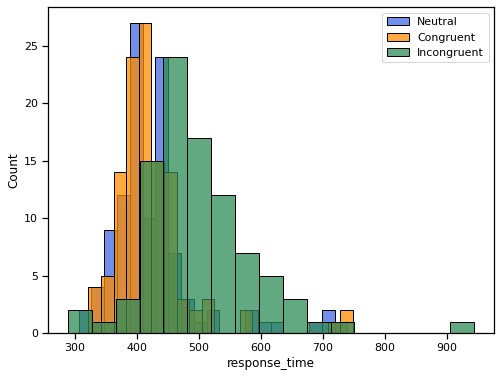

In [137]:
ttype_list = ["Neutral","Congruent","Incongruent"]
color_list = ['royalblue','darkorange','seagreen']
plt.figure(figsize=(8,6))
correct_flat = flat[flat.response_accuracy == 1]
for k, ttype in enumerate(ttype_list):
    sns.histplot(correct_flat[correct_flat.flanker_type == ttype].response_time, color=color_list[k])
plt.legend(ttype_list)

#### Looks like incongruent distributions are well separated from congruent and neutral. Just a single apparent outlier. [above]

### Quantify each contrast

In [138]:
import pingouin as pg

In [139]:
con = correct_flat[correct_flat.flanker_type == "Congruent"]
inc = correct_flat[correct_flat.flanker_type == "Incongruent"]
ntr = correct_flat[correct_flat.flanker_type == "Neutral"]
ci_res = pg.ttest(inc.response_time, con.response_time)
ci_res.insert(0,"contrast","I>C")
ni_res = pg.ttest(inc.response_time, ntr.response_time)
ni_res.insert(0,"contrast","I>N")
cn_res = pg.ttest(con.response_time, ntr.response_time)
cn_res.insert(0,"contrast","C>N")
res = pd.concat([ci_res, ni_res, cn_res])
res

,contrast,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,I>C,6.636352,161.153640,two-sided,4.655041e-10,"[53.83, 99.43]",0.960016,3.033e+07,1.00000
T-test,I>N,5.928422,176.422877,two-sided,1.572986e-08,"[48.06, 96.02]",0.853050,7.843e+05,1.00000
T-test,C>N,-0.475554,215.632227,two-sided,6.348733e-01,"[-23.63, 14.45]",0.063682,0.162,0.07626


#### C;N < I contrasts are robust and well powered. N vs. C does not appear to be meaningful

## Repeat reaction time characterization with first 120 trials - as in cognitive burst

In [140]:
first_block = correct_flat[correct_flat.block_number == 1]

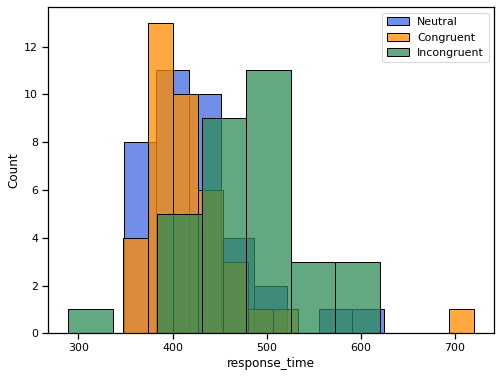

In [141]:
ttype_list = ["Neutral","Congruent","Incongruent"]
color_list = ['royalblue','darkorange','seagreen']
plt.figure(figsize=(8,6))
correct_flat = flat[flat.response_accuracy == 1]
for k, ttype in enumerate(ttype_list):
    sns.histplot(first_block[first_block.flanker_type == ttype].response_time, color=color_list[k])
plt.legend(ttype_list)

#### A little messier here, of course, using 1/3 of the data. One potential outlier in con trials. But still looks like I>C;N [above]

In [142]:
con = first_block[first_block.flanker_type == "Congruent"]
inc = first_block[first_block.flanker_type == "Incongruent"]
ntr = first_block[first_block.flanker_type == "Neutral"]
ci_res = pg.ttest(inc.response_time, con.response_time)
ci_res.insert(0,"contrast","I>C")
ni_res = pg.ttest(inc.response_time, ntr.response_time)
ni_res.insert(0,"contrast","I>N")
cn_res = pg.ttest(con.response_time, ntr.response_time)
cn_res.insert(0,"contrast","C>N")
res = pd.concat([ci_res, ni_res, cn_res])
res

,contrast,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,I>C,4.182923,63.927329,two-sided,0.000089,"[33.46, 94.65]",1.005885,260.999,0.986021
T-test,I>N,3.763564,63.299967,two-sided,0.000369,"[27.18, 88.7]",0.914929,74.172,0.962065
T-test,C>N,-0.438078,73.883312,two-sided,0.662608,"[-33.95, 21.71]",0.100500,0.258,0.071667


#### C;N < I contrasts are still significant and remain well powered. If anything, cohen's d increased. N vs. C does not appear to be meaningful
Worth a reminder at this point that the stats and power estimates here are based on the sledgehammer I>C;N flanker effects. If these were not readily apparent it would be time to panic. But these I>C;N estimates can not speak to the task's timing accuracy w.r.t. sensitivity to individual difference metrics. 

# Replicate everything above with second dataset. Not spelling everything out this time.

### Functions below are reusable so long as the flanker outputs do not change.

In [143]:
def flatten_flanker_df(DF):
    """Ugly, but serviceable. First time with this output format. Can clean up later."""
    
    resp = DF[DF.event_type == "Response"].copy()
    fix = DF[DF.event_type == "Fixation"].copy()
    stim = DF[DF.event_type == "Stimulus"].copy()

    # Non-response events
    non_resp_ints = ['experiment_start_timestamp',
     'block_start_timestamp',
     'trial_start_timestamp',
     'event_start_timestamp',
     'video_display_request_timestamp',
     'trial_offset',
     'event_offset']
    
    # Response events
    response_ints = ['response_touch_timestamp',
     'trial_offset',
     'response_accuracy']

    for n in non_resp_ints:
        fix[n] = fix[n].map(int)
        stim[n] = stim[n].map(int)

    for r in response_ints:
        resp[r] = resp[r].map(int)

    resp.response_time = resp.response_time.map(float)

    flat = fix[["block_number",
           "trial_number",
           "trial_type",
           'experiment_start_timestamp',
           'block_start_timestamp',
           'trial_start_timestamp']].copy()
    flat["flanker_type"] = resp.flanker_type.values
    flat["stim_trial_start_ts"] = stim.event_start_timestamp.values
    flat["stim_display_request_ts"] = stim.video_display_request_timestamp.values
    flat["response_timestamp"] = resp.response_touch_timestamp.values
    flat["response_time"] = resp.response_time.values
    flat["response_accuracy"] = resp.response_accuracy.values
    flat["block_to_fix_time"] = flat.trial_start_timestamp - flat.block_start_timestamp
    flat["fix_to_stim_time"] = flat.stim_trial_start_ts - flat.trial_start_timestamp
    flat["stim_time_to_display_time"] = flat.stim_display_request_ts - flat.stim_trial_start_ts
    flat["stim_to_response"] = flat.response_timestamp - flat.stim_display_request_ts # sanity check that response_time matches values directly computed from columns
    
    return(flat)


In [144]:
def get_resp_next_trial_intervals(DF):
    resp_to_next_interval = []
    for block in [1,2,3]:
        tmp = DF[DF.block_number == block]
        interval = [tmp.trial_start_timestamp.values[k] - tmp.response_timestamp.values[k-1] for k in np.arange(1,len(tmp)-1)]
        resp_to_next_interval.extend(interval)
    resp_to_next_interval = pd.Series(resp_to_next_interval)
    return(resp_to_next_interval)

In [145]:
def load_flanker_with_prefix(prefix):
    DF = pd.read_csv(f"{prefix}_test1.csv")
    for k in [2,3]:
        tmp = pd.read_csv(f"{prefix}_test{k}.csv")
        DF = pd.concat([DF, tmp], ignore_index=True)
    DF["flanker_type"] = DF.trial_type.map(flanker_type)
    DF["correct_resp"] = DF.trial_type.map(left_right)
    return(DF)

In [146]:
def stim_request_to_display_values(DF):
    s = DF.stim_time_to_display_time
    v = series_to_ms_value_counts(s)
    return(v)

In [147]:
def series_to_ms_value_counts(series):
    d = dict(series.value_counts())
    v = pd.DataFrame(columns=["time_interval_ms","count_at_interval"])
    v.time_interval_ms = d.keys()
    v.count_at_interval = d.values()
    v = v.sort_values("time_interval_ms").head()
    return(v)

In [148]:
def user_response_to_next_trial_interval(DF):
    resp_to_next_interval = []
    for block in [1,2,3]:
        tmp = DF[DF.block_number == block]
        interval = [tmp.trial_start_timestamp.values[k] - tmp.response_timestamp.values[k-1] for k in np.arange(1,len(tmp)-1)]
        resp_to_next_interval.extend(interval)
    resp_to_next_interval = pd.Series(resp_to_next_interval)
    ms_counts = series_to_ms_value_counts(resp_to_next_interval)
    return(ms_counts)

### Load and flatten data

In [149]:
prefix = "623936435197b94689825e92"
df = load_flanker_with_prefix(prefix)
flat = flatten_flanker_df(df)

## Sanity Checking

### Response Times

In [150]:
flat.groupby("flanker_type").response_time.mean()

flanker_type
Congruent      648.800000
Incongruent    671.108333
Neutral        620.233333
Name: response_time, dtype: float64

### Accuracy

In [151]:
flat.groupby("flanker_type").response_accuracy.mean() * 100

flanker_type
Congruent      98.333333
Incongruent    97.500000
Neutral        99.166667
Name: response_accuracy, dtype: float64

### Only Correct Trials

In [152]:
correct = flat[flat.response_accuracy ==1].copy() # copy, not view

In [153]:
correct.groupby("flanker_type").response_time.mean()

flanker_type
Congruent      641.754237
Incongruent    664.606838
Neutral        621.151261
Name: response_time, dtype: float64

### General behavioral pattern above looks nominally correct, but not obviously distinct.

## Timing performance

In [154]:
stim_request_to_display_values(flat) 

,time_interval_ms,count_at_interval
0,0,293
1,1,67


In [155]:
user_response_to_next_trial_interval(flat)

,time_interval_ms,count_at_interval
2,0,28
0,1,200
1,2,107
3,3,11
4,4,5


### The inter-event intervals reported are very similar to the inital dataset and highlight realtime mismatches. Min = 0 (~19%), max = 4ms. 

## RT Characterization, all 360 trials

In [157]:
def flanker_rt_hist(DF):
    ttype_list = ["Neutral","Congruent","Incongruent"]
    color_list = ['royalblue','darkorange','seagreen']
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    for k, ttype in enumerate(ttype_list):
        sns.histplot(DF[DF.flanker_type == ttype].response_time, color=color_list[k], ax=ax)
    ax.legend(ttype_list)
    ax.set_title("Flanker RT Distributions", fontsize=18)

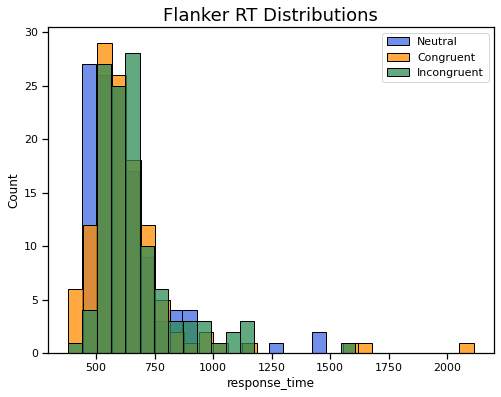

In [158]:
flanker_rt_hist(correct)

### Trial type separation not as clear as the first dataset [above]

### Quantify Contrasts

In [159]:
def flanker_ttests(DF):
    ## Not editing subsets, so just using a view
    con = DF[DF.flanker_type == "Congruent"]
    inc = DF[DF.flanker_type == "Incongruent"]
    ntr = DF[DF.flanker_type == "Neutral"]
    ci_res = pg.ttest(inc.response_time, con.response_time)
    ci_res.insert(0,"contrast","I>C")
    ni_res = pg.ttest(inc.response_time, ntr.response_time)
    ni_res.insert(0,"contrast","I>N")
    cn_res = pg.ttest(con.response_time, ntr.response_time)
    cn_res.insert(0,"contrast","C>N")
    res = pd.concat([ci_res, ni_res, cn_res])
    return(res)

In [160]:
flanker_ttests(correct)

,contrast,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,I>C,0.863357,216.286420,two-sided,0.388898,"[-29.32, 75.02]",0.112502,0.203,0.137813
T-test,I>N,1.932346,233.998070,two-sided,0.054524,"[-0.85, 87.76]",0.251549,0.824,0.485779
T-test,C>N,0.776778,217.768116,two-sided,0.438133,"[-31.67, 72.88]",0.101032,0.189,0.121042


### **There is not a reliable trial type difference in this dataset**. Typical sledgehammer effects are not detected.

## Reduced to 120 Trial as in Cog Burst

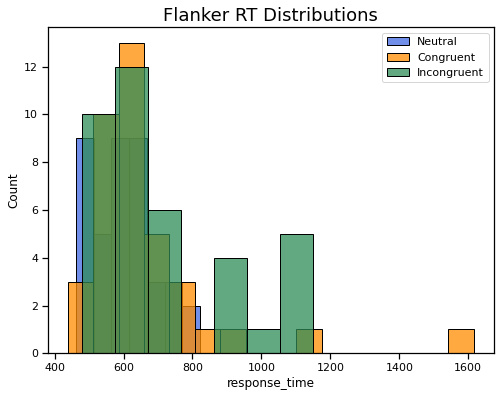

In [161]:
first_block = correct[correct.block_number == 1].copy()
flanker_rt_hist(first_block)

#### There are several apparent outliers in con and inc - not neutral. But the modes of the distributions look very well aligned (not different)

### Quantify contrasts

In [162]:
flanker_ttests(first_block)

,contrast,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,I>C,1.115591,74.000000,two-sided,0.268207,"[-40.48, 143.48]",0.255934,0.406,0.196324
T-test,I>N,3.415113,52.058105,two-sided,0.001243,"[49.2, 189.38]",0.786530,29.729,0.928936
T-test,C>N,1.854540,50.603610,two-sided,0.069493,"[-5.61, 141.18]",0.427464,1.027,0.461502


#### The neutral trials do not have any outliers, and are significantly faster than either congruent or incongruent trials. But the base (typically very large) effect between con and inc is not reliable.

## If we have noisy data, a first pass is often to remove outliers

In [176]:
zscore = lambda x: (x - x.mean()) / x.std()
def return_mask_by_sd(vec, num_sd=3, two_sided = False):
    zvals = zscore(vec)
    mask = np.zeros(zvals.shape)
    mask[np.where(zvals >= num_sd)] = 1
    if two_sided is True:
        mask[np.where(zvals <= -1*num_sd)] = 1
    return(mask)    

In [164]:
correct["outlier"] = return_mask_by_sd(correct.response_time, num_sd = 2.5)

### In full n=360 dataset

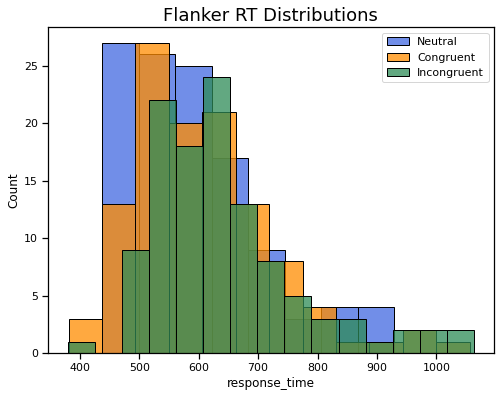

In [165]:
flanker_rt_hist(correct[correct.outlier == 0])

#### Might be better

In [166]:
flanker_ttests(correct[correct.outlier == 0])

,contrast,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,I>C,2.255657,224.024964,two-sided,0.025058,"[4.67, 69.17]",0.299505,1.569,0.612813
T-test,I>N,3.010778,220.659758,two-sided,0.002909,"[16.38, 78.45]",0.399288,9.81,0.851213
T-test,C>N,0.689677,225.161302,two-sided,0.491108,"[-19.49, 40.48]",0.091184,0.181,0.105578


#### With outliers removed, the full 360 dataset results are generally consistent with initial dataset, I>C;N, C==N, though much weaker effect sizes

## With n=120 first block

In [167]:
first_block["outlier"] = return_mask_by_sd(first_block.response_time, num_sd = 2.5)

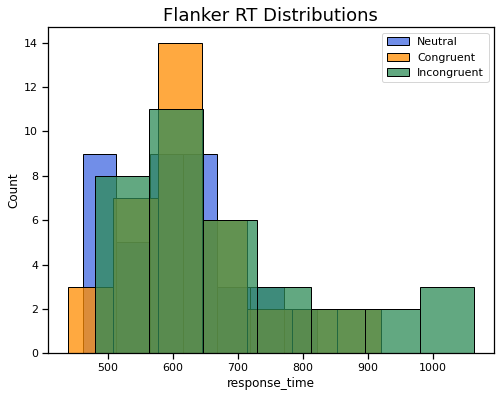

In [168]:
flanker_rt_hist(first_block[first_block.outlier == 0])

In [169]:
flanker_ttests(first_block[first_block.outlier == 0])

,contrast,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,I>C,1.732356,59.263086,two-sided,0.088412,"[-8.59, 119.45]",0.413458,0.875,0.404333
T-test,I>N,2.744762,53.196942,two-sided,0.008240,"[22.47, 144.43]",0.656750,5.65,0.799549
T-test,C>N,1.223858,69.848567,two-sided,0.225118,"[-17.65, 73.7]",0.283242,0.453,0.229479


### After thresholding, I>C approaches a marginal effect in cog burst sample size; C==N. So, better, but still not good.

#### Try an SD=2 threshold?

In [170]:
first_block["outlier"] = return_mask_by_sd(first_block.response_time, num_sd = 2)

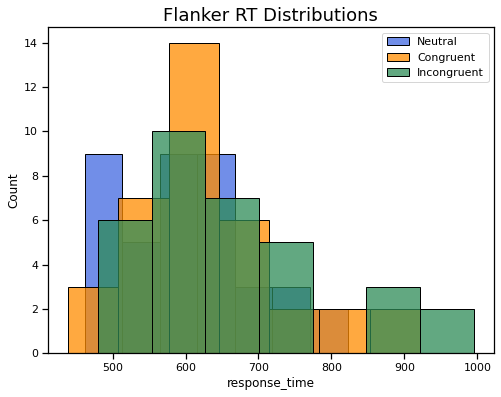

In [171]:
flanker_rt_hist(first_block[first_block.outlier == 0])

In [172]:
flanker_ttests(first_block[first_block.outlier == 0])

,contrast,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,I>C,1.136071,61.545155,two-sided,0.260331,"[-24.94, 90.57]",0.276360,0.429,0.204373
T-test,I>N,2.243960,55.751751,two-sided,0.028824,"[6.52, 115.16]",0.545440,2.034,0.628540
T-test,C>N,1.223858,69.848567,two-sided,0.225118,"[-17.65, 73.7]",0.283242,0.453,0.229479


### Not helpful. Removing outliers continues to erode the trial type effects ; I>N still remains reliable

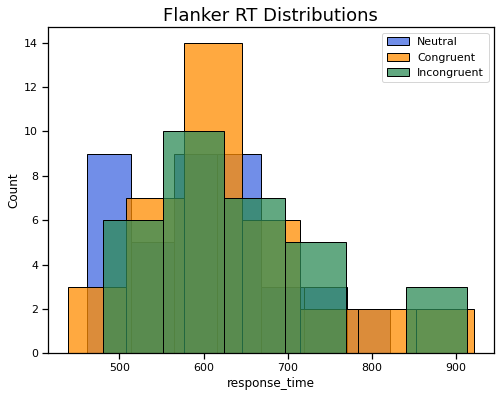

In [173]:
first_block["outlier"] = return_mask_by_sd(first_block.response_time, num_sd = 1.5)
flanker_rt_hist(first_block[first_block.outlier == 0])

In [174]:
flanker_ttests(first_block[first_block.outlier == 0])

,contrast,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,I>C,0.496602,63.135433,two-sided,0.621195,"[-39.41, 65.47]",0.121862,0.279,0.077934
T-test,I>N,1.691183,58.954989,two-sided,0.096082,"[-7.52, 89.64]",0.412968,0.828,0.398268
T-test,C>N,1.223858,69.848567,two-sided,0.225118,"[-17.65, 73.7]",0.283242,0.453,0.229479


### Tighter trimming just renders all effects nonsignificant again.

#### Note that these results only trimmed the upper values to avoid trimming lower values from neutral and con trials (and maximizing likelihood of finding a I>C result by removing outliers); but replicating with two tailed trimming didn't remove any of the lower values. Outliers were restricted to exceptionally long RTs.